### Connect to Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

In [2]:
#%cd /gdrive/My Drive/ANN&DL/hw2



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/training/Training.csv


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)


Load the dataset

In [6]:
#dataset = pd.read_csv('Training.csv')
#print(dataset.shape)
#dataset.head()

In [7]:
dataset = pd.read_csv('../input/training/Training.csv',
                     low_memory = False)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [9]:

# change the dtype to 'float64'
dataset = dataset.astype('float32')
  
# Print the array after changing
# the data type
dataset.info()
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


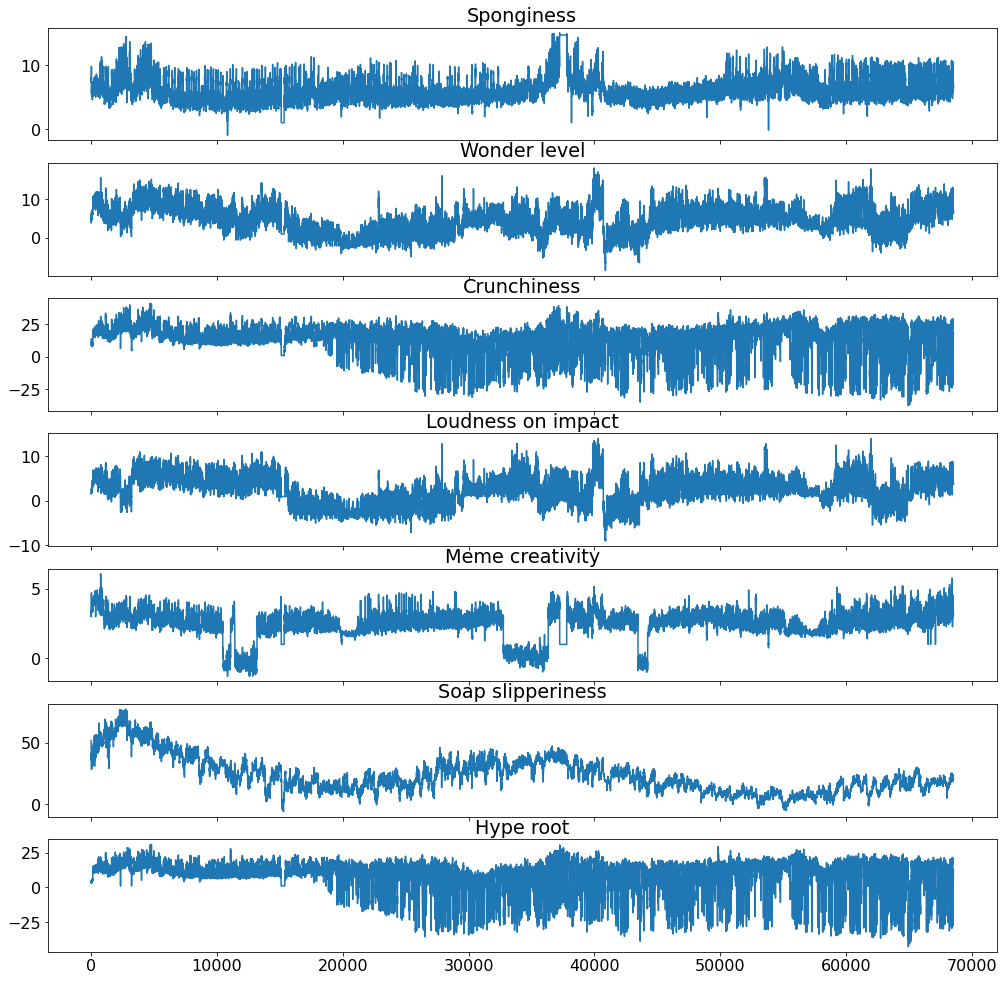

In [10]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(67000, 7) (1528, 7)


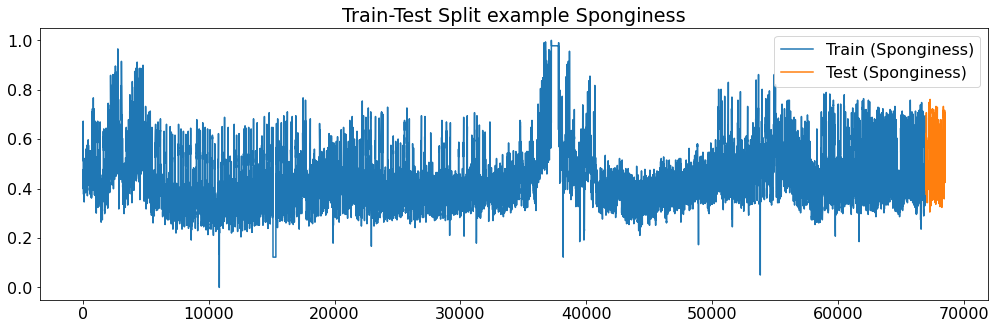

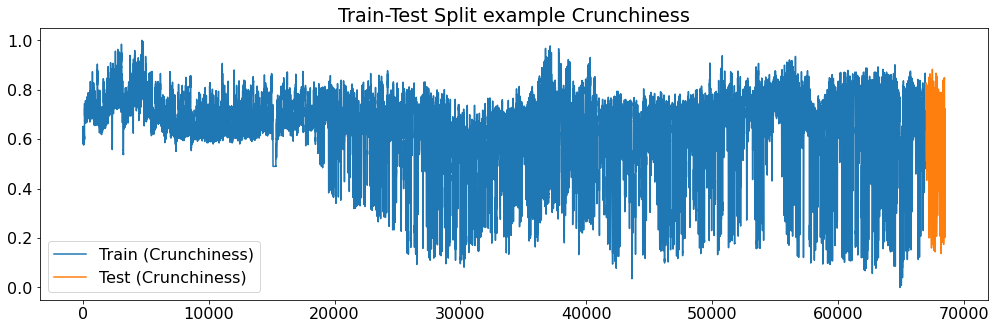

In [11]:
test_size = 1528
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split example Sponginess')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split example Crunchiness')
plt.legend()
plt.show()


In [12]:
window = 200
stride = 10

In [13]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [14]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecating (Direct)

In [15]:
target_labels = dataset.columns
telescope = 864

In [16]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6594, 200, 7), (6594, 864, 7), (54, 200, 7), (54, 864, 7))

Defining a TimeseriesGenerator

In [17]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

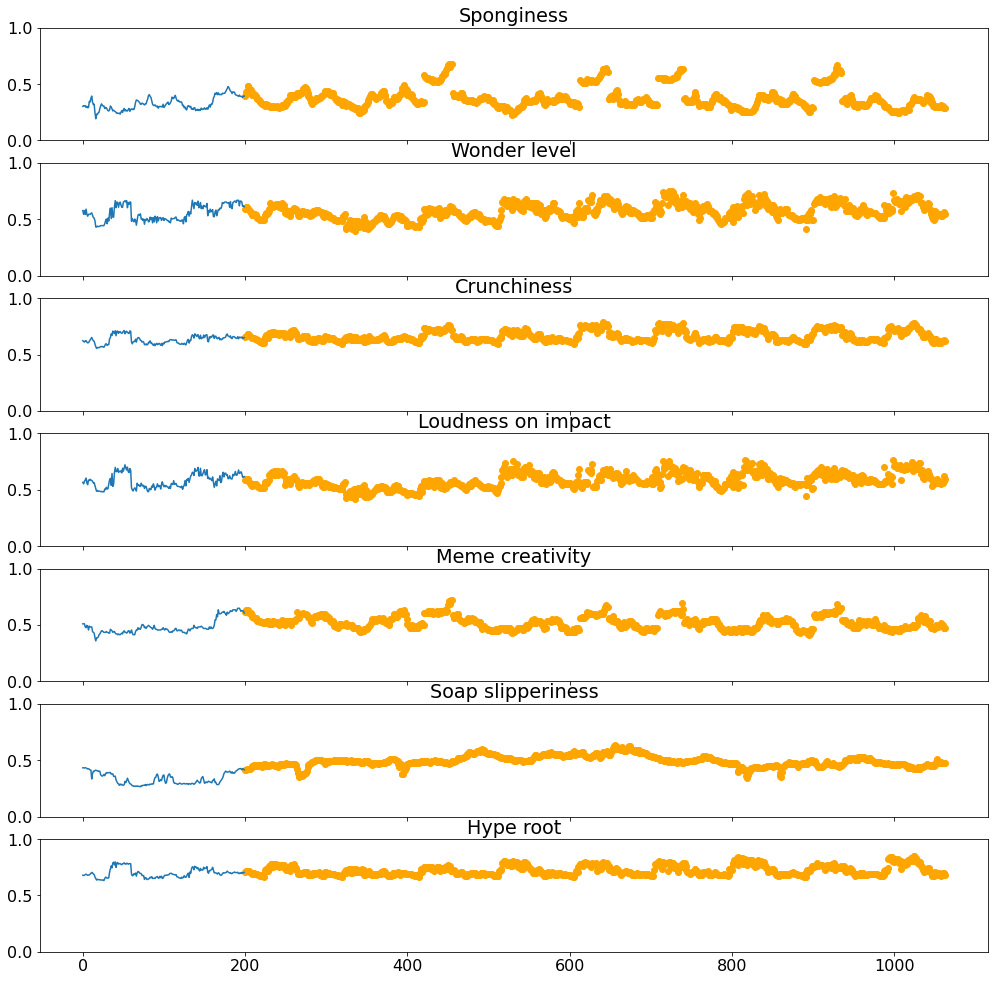

In [18]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [19]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [20]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    
    convlstm = tfkl.Dropout(.5)(convlstm)
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

2021-12-26 18:57:17.428018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 18:57:17.521228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 18:57:17.522278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 18:57:17.524131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          36864     
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 256)           0     

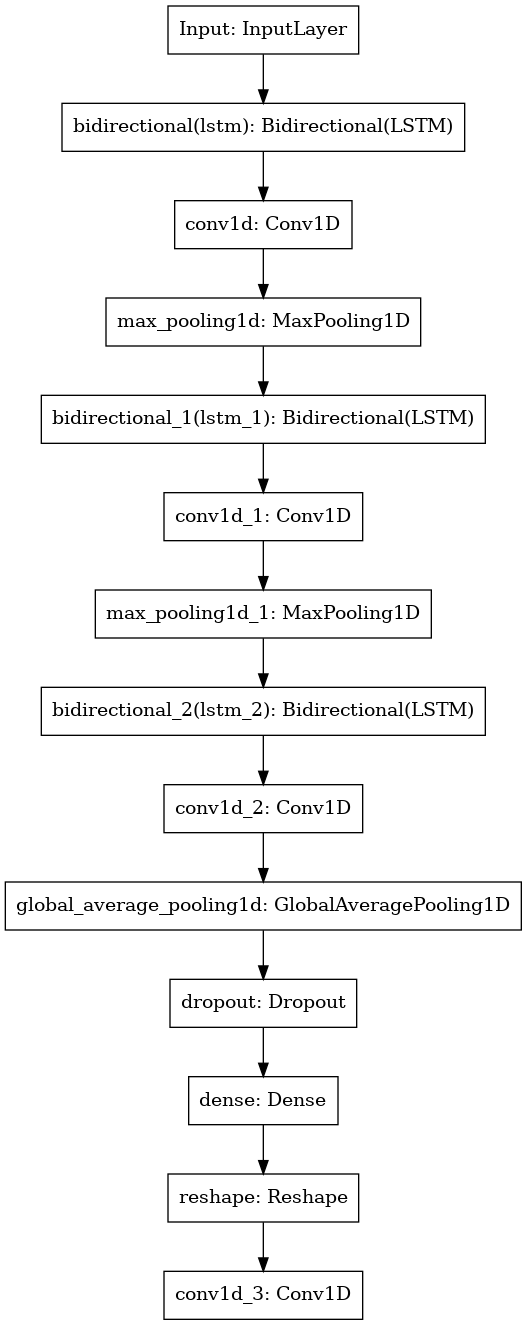

In [21]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [22]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2021-12-26 18:57:22.256919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-12-26 18:57:29.364891: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 19s 71ms/step - loss: 0.1992 - mae: 0.3814 - val_loss: 0.1124 - val_mae: 0.2593
Epoch 2/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0670 - mae: 0.1980 - val_loss: 0.0440 - val_mae: 0.1609
Epoch 3/200
93/93 [==============================] - 5s 54ms/step - loss: 0.0282 - mae: 0.1278 - val_loss: 0.0284 - val_mae: 0.1243
Epoch 4/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0197 - mae: 0.1053 - val_loss: 0.0243 - val_mae: 0.1155
Epoch 5/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0172 - mae: 0.0985 - val_loss: 0.0231 - val_mae: 0.1125
Epoch 6/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0161 - mae: 0.0952 - val_loss: 0.0223 - val_mae: 0.1100
Epoch 7/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0155 - mae: 0.0932 - val_loss: 0.0217 - val_mae: 0.1087
Epoch 8/200
93/93 [==============================] - 5s 53ms/step - loss: 0.0153 - mae:

In [23]:
model.save('MultivariateForecasting')
#model = tfk.models.load_model('DirectForecasting')

2021-12-26 19:03:41.538136: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


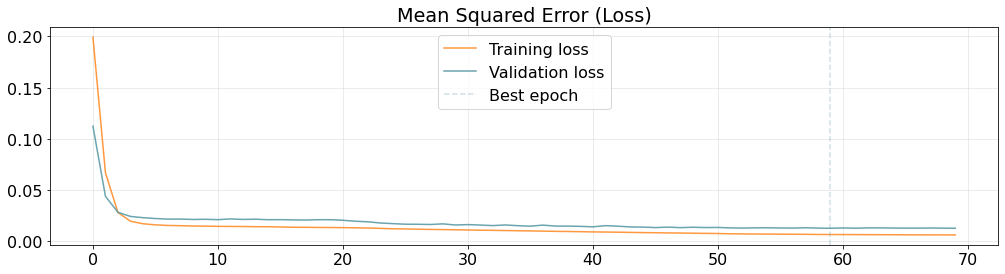

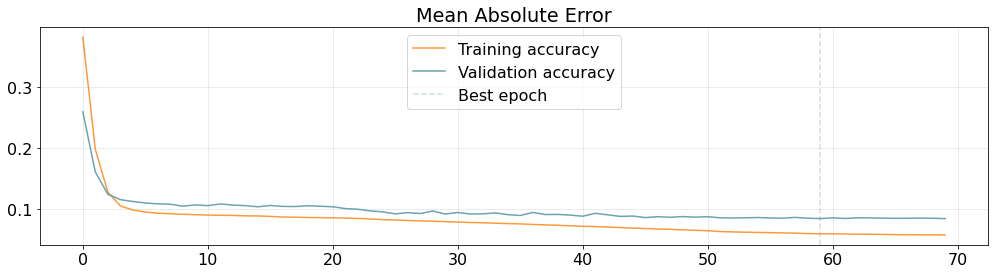

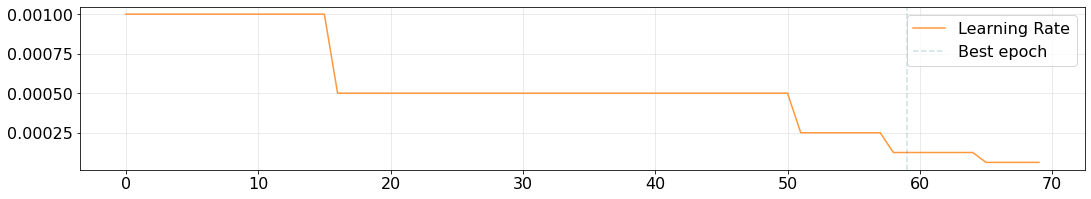

In [24]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Test evaluation

In [25]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(54, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.015591271>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.093553565>)

In [26]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

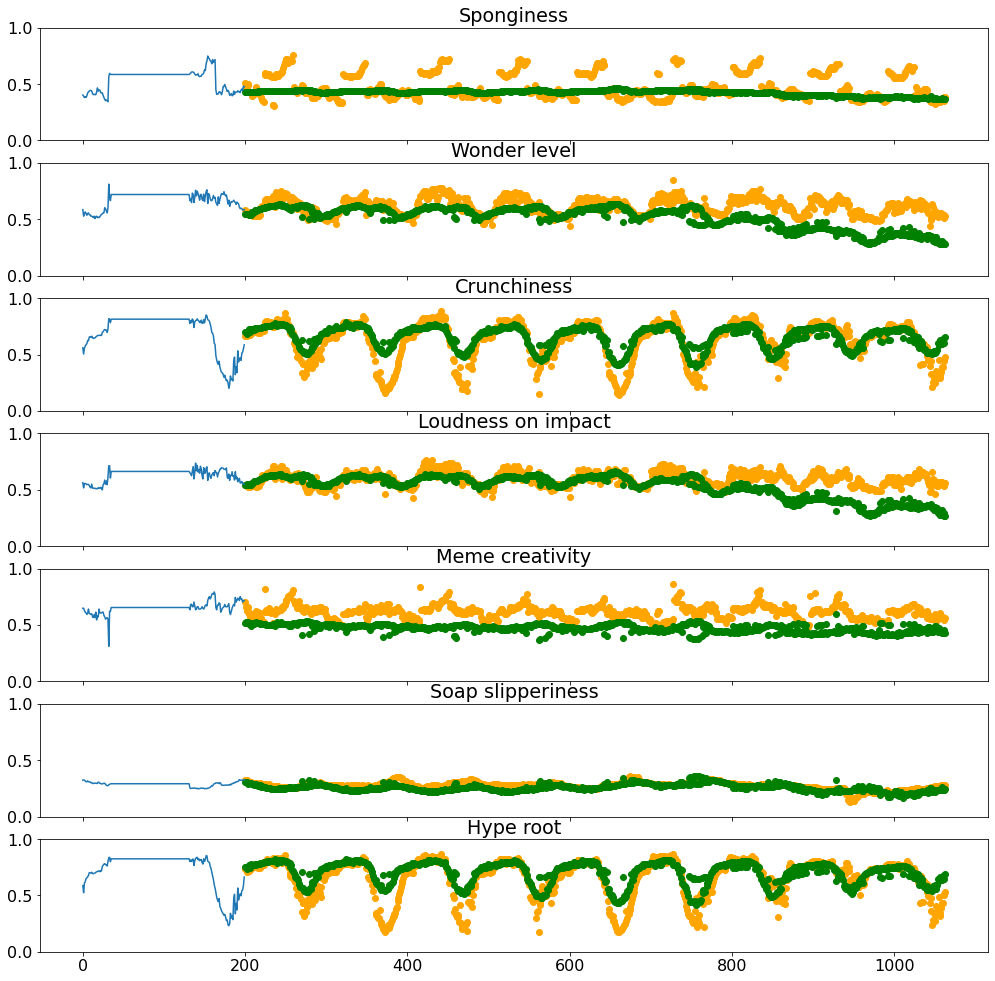

In [27]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

Predict the future 

In [28]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [29]:
future_predictions = model.predict(future)

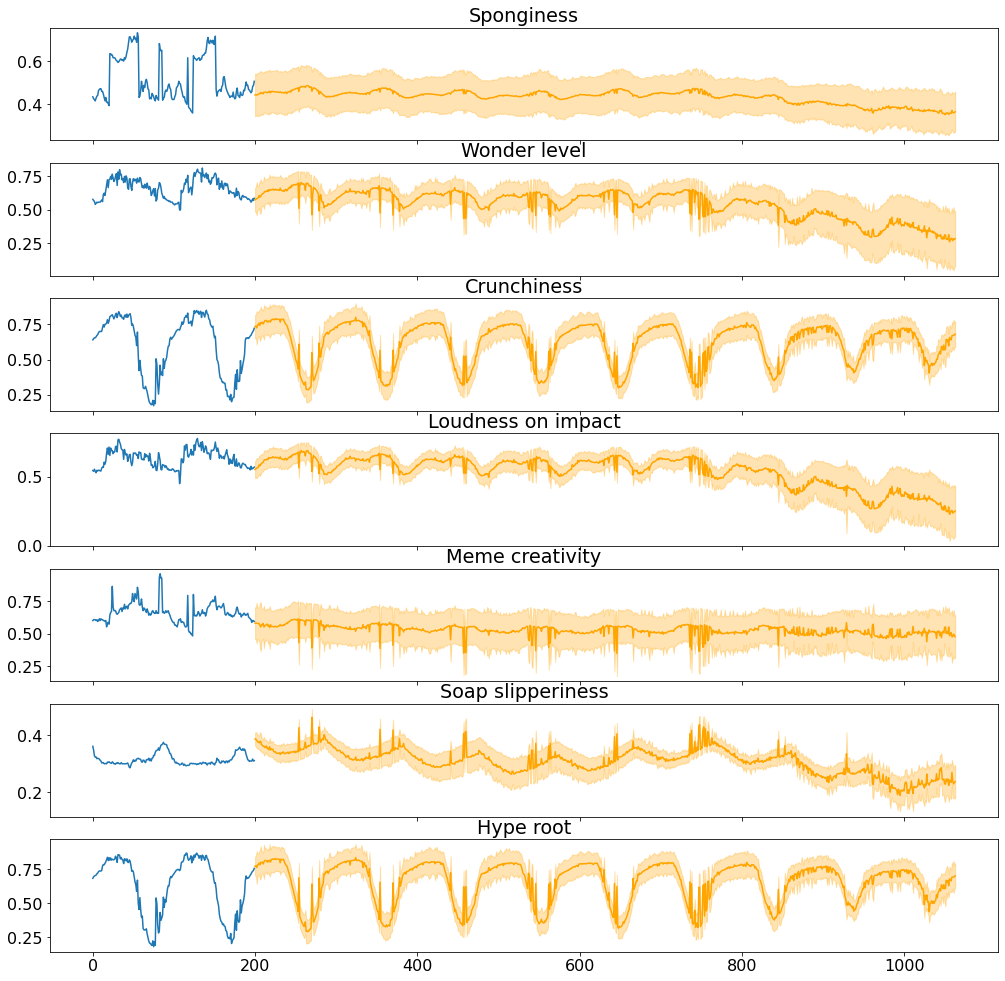

In [30]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

### Multivariate Forecasting (Autoregression)

In [31]:
target_labels = dataset.columns
telescope = 1

In [32]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6680, 200, 7), (6680, 1, 7), (140, 200, 7), (140, 1, 7))

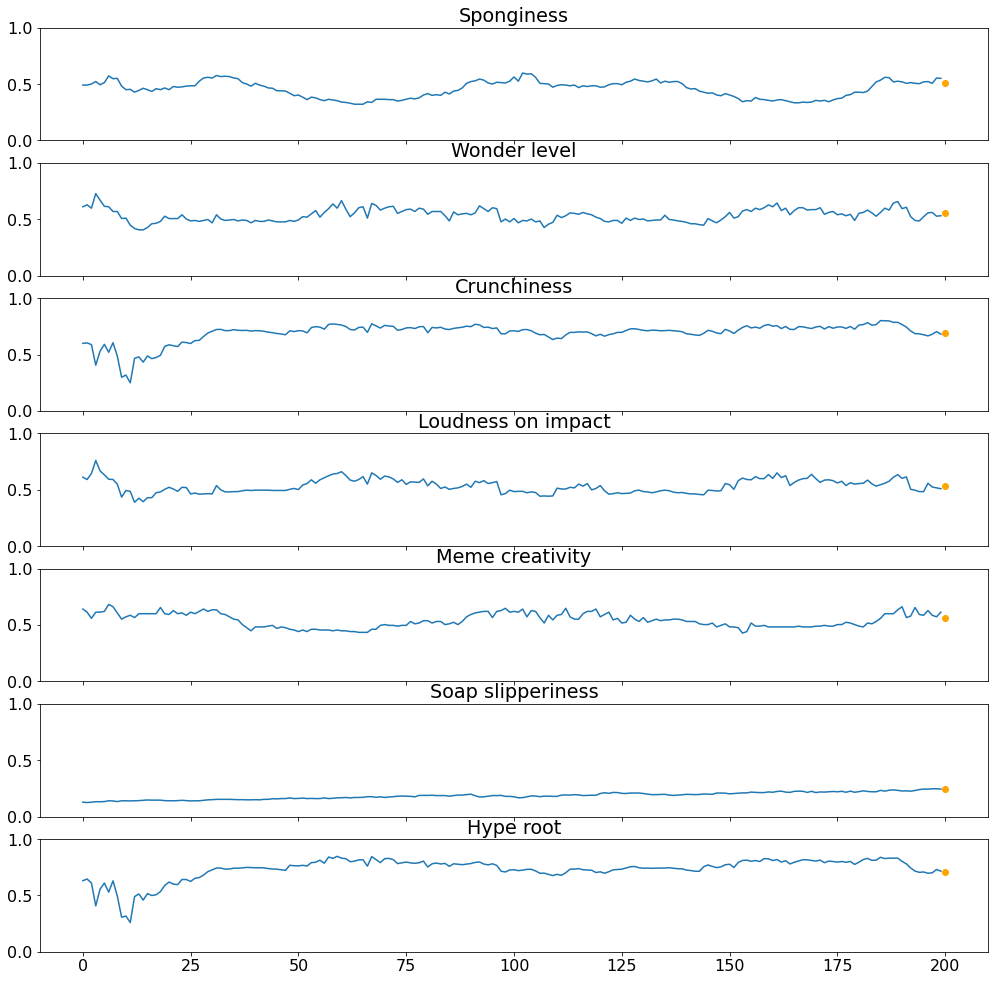

In [33]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [34]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 128)          36864     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 256)           0     

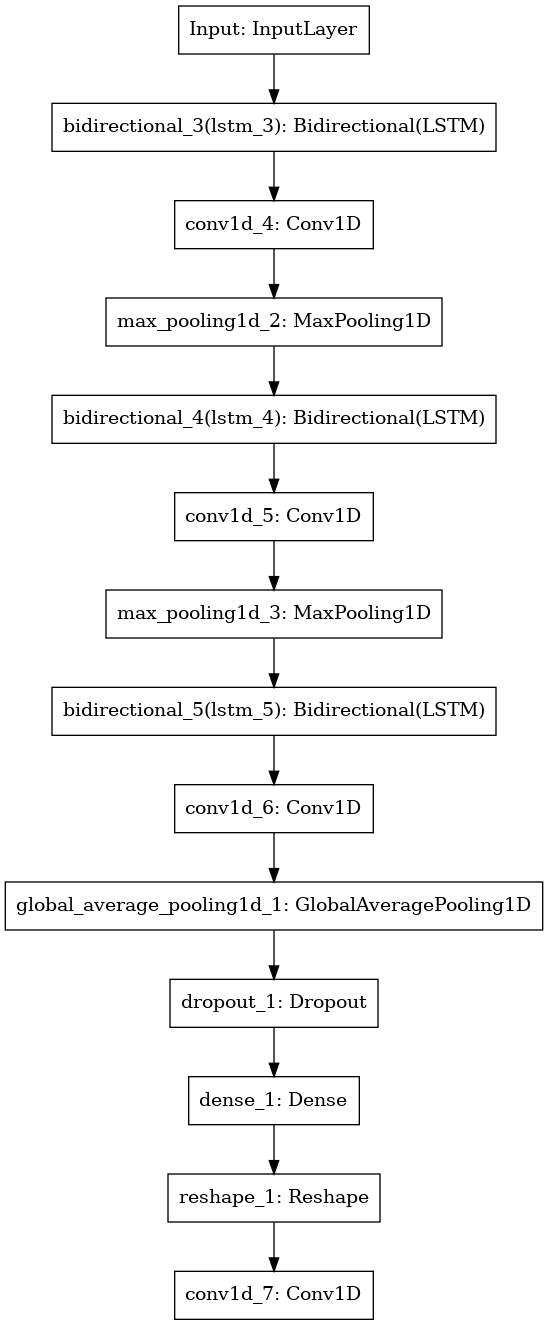

In [35]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [36]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
94/94 [==============================] - 16s 71ms/step - loss: 0.0743 - mae: 0.2056 - val_loss: 0.0189 - val_mae: 0.1005
Epoch 2/200
94/94 [==============================] - 5s 51ms/step - loss: 0.0196 - mae: 0.1086 - val_loss: 0.0221 - val_mae: 0.1085
Epoch 3/200
94/94 [==============================] - 5s 51ms/step - loss: 0.0181 - mae: 0.1044 - val_loss: 0.0191 - val_mae: 0.1113
Epoch 4/200
94/94 [==============================] - 5s 53ms/step - loss: 0.0163 - mae: 0.0995 - val_loss: 0.0144 - val_mae: 0.0929
Epoch 5/200
94/94 [==============================] - 5s 52ms/step - loss: 0.0159 - mae: 0.0981 - val_loss: 0.0145 - val_mae: 0.0941
Epoch 6/200
94/94 [==============================] - 5s 52ms/step - loss: 0.0147 - mae: 0.0937 - val_loss: 0.0119 - val_mae: 0.0820
Epoch 7/200
94/94 [==============================] - 5s 51ms/step - loss: 0.0137 - mae: 0.0908 - val_loss: 0.0135 - val_mae: 0.0924
Epoch 8/200
94/94 [==============================] - 5s 52ms/step - loss: 0

In [37]:
model.save('multivariateForecastingAutoregressing')
#model = tfk.models.load_model('AuroregressiveForecasting')

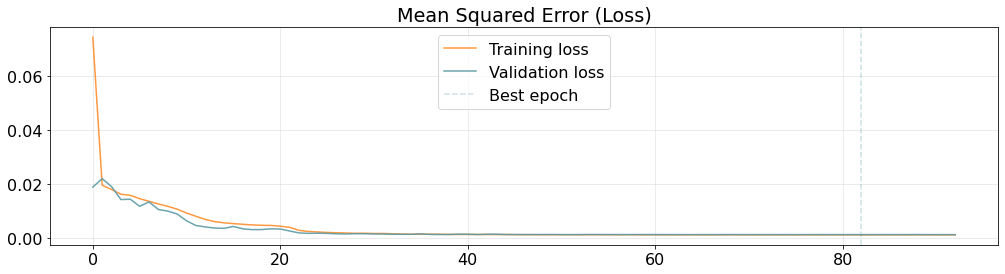

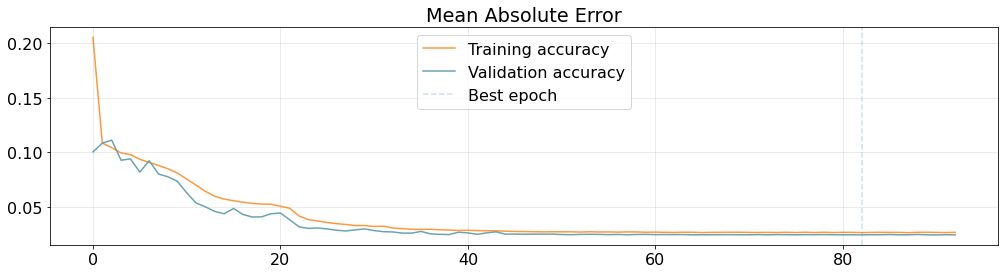

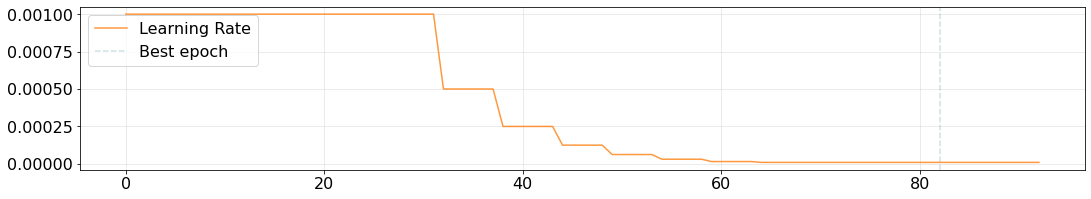

In [38]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [39]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(140, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0076127667>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.03671293>)

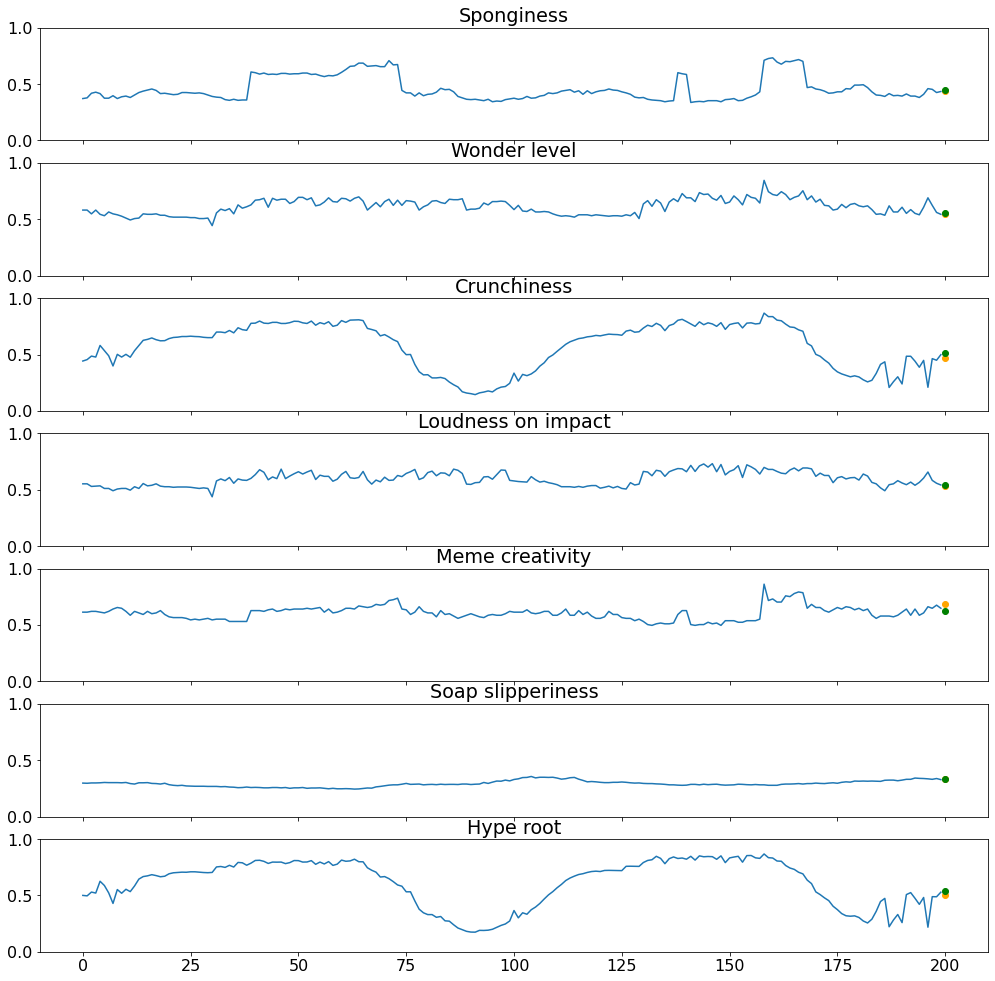

In [40]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [41]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((54, 200, 7), (54, 864, 7))

In [42]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [43]:
reg_predictions.shape

(54, 864, 7)

In [44]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=3.3665957>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47610918>)

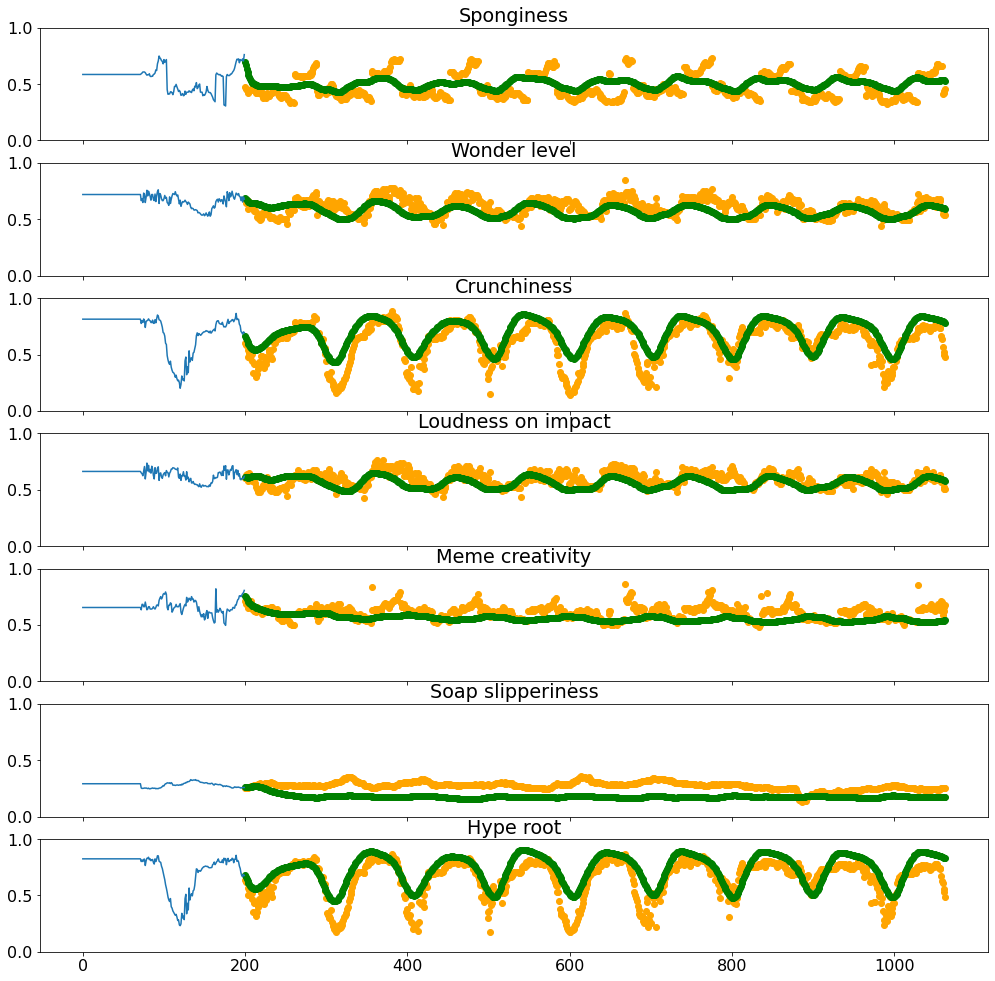

In [45]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

predict the future

In [46]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [47]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

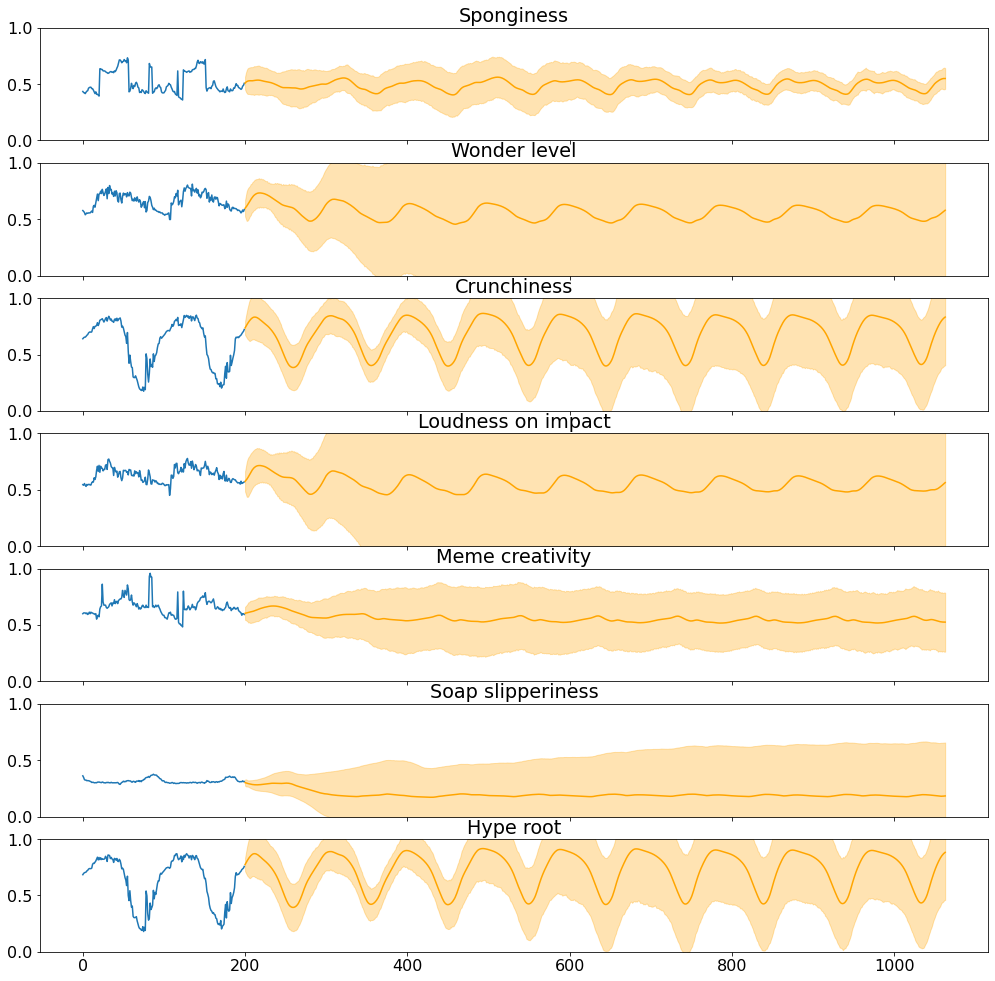

In [48]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

### Attention Is All You Need